next-steps checklist

1) run on CALMS dataset
	•	GlobalTSNE: use your new InputSet for Columns; save templates + coords.
	•	GlobalKMeans: fit on templates; also run a few K values (e.g., 50/100/150) and save labels.
	•	GlobalWard: build linkage on the same templates; persist model.joblib/.npz.

2) visualizations (CALMS)
	•	t-SNE scatter colored by k-means (pick K) and by Ward recut (choose cut).
	•	t-SNE scatter colored by ground truth labels (Columns GT).
	•	Raster/time plots per (seq, persp) for k-means, Ward, and GT.

3) compare clustering vs GT
	•	Confusion matrices: GT vs (k-means, Ward cut).
	•	Basic metrics: NMI/ARI, cluster purity, per-class recall.
	•	Per-cluster thumbnails: top-N frames per cluster to sanity-check.

4) lightweight interactivity
	•	Prototype a Streamlit app:
	•	inputset selector, K slider, Ward cut slider.
	•	t-SNE scatter with hover tooltips.
	•	per-sequence raster + quick filters.
	•	optional: video preview hook (path + frame index).

5) model training (start simple)
	•	XGBoost classifier on standardized feature space (same inputset/scaler).
	•	Train on Columns GT; log CV metrics; save model + scaler + params.
	•	Add fast inference path (NearestNeighbors to centroids as baseline).

6) video segment browsing
	•	Utility: map cluster or GT labels → contiguous segments (min-length merge).
	•	Viewer: given (seq, persp, t0..t1) open video slice (or export list).

7) cross-dataset transfer (Columns → ESI)
	•	Reuse Columns scaler + model; standardize ESI with same inputset.
	•	Predict ESI labels; export per-(seq, persp) label tracks.
	•	Spot-check with t-SNE overlay (ESI points, colored by predicted label).

8) provenance & bookkeeping
	•	Ensure every run writes provenance.json with: inputset, resolved inputs, fingerprints, scaler dims, K/cut, seeds.
	•	Keep index.csv rows minimal; rely on provenance for full details.

9) small automation
	•	Notebook cells → scripts (CLI): run_tsne, run_kmeans, run_ward, viz_tsne, viz_raster.
	•	Add a simple make/bash pipeline to reproduce a full experiment from an inputset.

that should carry you from “works in notebook” to a tidy, repeatable pipeline you can compare, visualize, and transfer across datasets.

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path


In [2]:
import importlib
import dataset as ds
import features
importlib.reload(ds)
importlib.reload(features)

<module 'features' from '/Users/jacob/Documents/GitHub/EcodylicScience/behavior/features.py'>

Centralized notebook for calling other function

# Datasets and operations

# CALMS21

In [3]:
name = "calms21"
# Choose a base directory (will be created if it doesn't exist)
base = "/Volumes/JD-SSD/mice_data/calms21/dataset/"
# Only include roots you actually need right now:

manifest_path = ds.new_dataset_manifest(
    name=name,
    base_dir=base,
    version="0.1.0",
    index_format="group/sequence",
)
print(Path(manifest_path).read_text().splitlines()[:30])  # peek first lines

Wrote dataset manifest -> /Volumes/JD-SSD/mice_data/calms21/dataset/dataset.yaml
['# ==========================================================', '# DATASET MANIFEST (extensible YAML)', '# Minimal required fields above; append optional fields below', '# Common OPTIONAL fields you may add later:', '#   fps_default: 30.0', '#   resolution_default: [1920, 1080]', '#   n_animals_default: 2', '#   species: ""', '#   groups:                      # [{id, notes, condition, date, ...}]', '#   sequences:                   # [{id, group, media_path, pose_path, fps, n_frames, n_animals, ...}]', '#   splits:                      # {task1_train: [...], task1_test: [...], ...}', '#   labels_map:                  # {0: attack, 1: investigation, ...}', '#   skeleton:                    # [[p1, p2], ...]', '#   bodyparts:                   # ["snout","neck",...]', '#   processing:                  # [{step, time, params_hash, code_commit, ...}]', '#   pose_model:                  # {name, engine, checkp

### Load existing

In [21]:
# Load existing manifest
manifest_path = '/Volumes/JD-SSD/mice_data/calms21/dataset/dataset.yaml'
importlib.reload(ds)
dataset = ds.Dataset(manifest_path)
dataset.load()

Dataset(manifest_path='/Volumes/JD-SSD/mice_data/calms21/dataset/dataset.yaml', name='calms21', version='0.1.0', format='yaml', roots={'media': '/Volumes/JD-SSD/mice_data/calms21/dataset/media', 'features': '/Volumes/JD-SSD/mice_data/calms21/dataset/features', 'labels': '/Volumes/JD-SSD/mice_data/calms21/dataset/labels', 'models': '/Volumes/JD-SSD/mice_data/calms21/dataset/models', 'tracks': '/Volumes/JD-SSD/mice_data/calms21/dataset/tracks', 'tracks_raw': '/Volumes/JD-SSD/mice_data/calms21/dataset/tracks_raw'}, meta={})

### Index and convert

In [5]:
# Index videos (no symlinks, just absolute paths in media/index.csv)
dataset.index_media(
    search_dirs=[
        "/Volumes/JD-SSD/mice_data/calms21/task1_videos_mp4/",
    ],
    extensions=(".mp4", ".avi")
)
dataset.index_tracks_raw(
    search_dirs=["/Volumes/JD-SSD/mice_data/calms21/data"],
    patterns="calms*.npy",       
    src_format="calms21_npy",
    multi_sequences_per_file=True,
    group_from="filename"
)

[index_media] Wrote 91 entries -> /Volumes/JD-SSD/mice_data/calms21/dataset/media/index.csv
[index_tracks_raw] 6 -> /Volumes/JD-SSD/mice_data/calms21/dataset/tracks_raw/index.csv


PosixPath('/Volumes/JD-SSD/mice_data/calms21/dataset/tracks_raw/index.csv')

In [40]:
dataset.convert_all_tracks(params={"neck_idx": None, "tail_idx": None}, overwrite=True, group_from='filename')

In [22]:
dataset.list_groups()

['calms21_task1_test',
 'calms21_task1_train',
 'calms21_task2_test',
 'calms21_task2_train',
 'calms21_task3_test',
 'calms21_task3_train']

## Features

### PoseDistance and Wavelet

In [15]:
import features
importlib.reload(features)
feat = features.PairPoseDistancePCA(params={
    "n_components": 6,
    "pose_n": 7,
})
run_id = dataset.run_feature(feat, groups=['calms21_task1_train'])

[feature:pair-posedistance-pca] completed run_id=0.1-d2cdb45ffd -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/pair-posedistance-pca/0.1-d2cdb45ffd


In [ ]:
feat_wav = features.PairWavelet(params={
    "fps_default": 30.0,
    "f_min": 0.2,
    "f_max": 5.0,
    "n_freq": 25,
    "wavelet": "cmor1.5-1.0",
    "log_floor": -3.0,
})
wav_run = dataset.run_feature(
    feat_wav,
    input_kind="feature",
    input_feature="pair-posedistance-pca",   # name of prior feature
    # optionally scope by groups or sequences:
    groups=['calms21_task1_train']
)

[feature:pair-posedistance-wavelet] completed run_id=0.1-88d79630c2 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/pair-posedistance-wavelet/0.1-88d79630c2


/Users/jacob/Documents/GitHub/EcodylicScience/behavior/dataset.py:1448: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2025-10-31T10:56:16.935385+00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[sel, "finished_at"] =  finished_at


### Pair-Egocentric and Wavelet

In [70]:
feat = features.PairEgocentricFeatures(params={
    "neck_idx": 3,
    "tail_base_idx": 6,
    # "fps_default": 30.0,
})
run_id = dataset.run_feature(feat, groups=["calms21_task1_train"],overwrite=True)

[feature:pair-egocentric] completed run_id=0.1-5f7ddf53ba -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/pair-egocentric/0.1-5f7ddf53ba


In [ ]:
## wavelet (refine so can change parameters)
feat_wav = features.PairWavelet(params={
    "fps_default": 30.0,
    "f_min": 0.2,
    "f_max": 5.0,
    "n_freq": 25,
    "wavelet": "cmor1.5-1.0",
    "log_floor": -3.0,
})
wav_run = dataset.run_feature(
    feat_wav,
    input_kind="feature",
    input_feature="pair-egocentric",   # name of prior feature
    input_run_id=None,                     # or a specific run_id; None => latest
    # optionally scope by groups or sequences:
    # groups=['calms21_task1_train']
)

[feature:pair-posedistance-wavelet] completed run_id=0.1-88d79630c2 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/pair-posedistance-wavelet/0.1-88d79630c2


# CRIMS 13
https://data.caltech.edu/records/4emt5-b0t10


# ESI 11-11

In [17]:
name = "esi11-11"
# Choose a base directory (will be created if it doesn't exist)
base = "/Volumes/JD-SSD/ESI-mice/dataset1/"

manifest_path = ds.new_dataset_manifest(
    name=name,
    base_dir=base,
    version="0.1.0",
    index_format="group/sequence",
)
print(Path(manifest_path).read_text().splitlines()[:30])  # peek first lines

Wrote dataset manifest -> /Volumes/JD-SSD/ESI-mice/dataset1/dataset.yaml
['# ==========================================================', '# DATASET MANIFEST (extensible YAML)', '# Minimal required fields above; append optional fields below', '# Common OPTIONAL fields you may add later:', '#   fps_default: 30.0', '#   resolution_default: [1920, 1080]', '#   n_animals_default: 2', '#   species: ""', '#   groups:                      # [{id, notes, condition, date, ...}]', '#   sequences:                   # [{id, group, media_path, pose_path, fps, n_frames, n_animals, ...}]', '#   splits:                      # {task1_train: [...], task1_test: [...], ...}', '#   labels_map:                  # {0: attack, 1: investigation, ...}', '#   skeleton:                    # [[p1, p2], ...]', '#   bodyparts:                   # ["snout","neck",...]', '#   processing:                  # [{step, time, params_hash, code_commit, ...}]', '#   pose_model:                  # {name, engine, checkpoint, co

## Load existing

In [3]:
base = "/Volumes/JD-SSD/ESI-mice/dataset1/"
importlib.reload(ds)
dataset = ds.Dataset(base)
dataset.load()
# Index native TRex NPZs (per id)
dataset.index_tracks_raw(
    search_dirs=["/Volumes/JD-SSD/ESI-mice/data"],
    patterns="*.npz",
    src_format="trex_npz",
    multi_sequences_per_file=False
)
dataset.convert_all_tracks(merge_per_sequence=True)


[index_tracks_raw] 4 -> /Volumes/JD-SSD/ESI-mice/dataset1/tracks_raw/index.csv


In [67]:
dataset.list_sequences()

['concat_2024-11-11']

### PoseDistance and Wavelet

In [27]:
#### PoseDistance and Wavelet
feat = features.PairPoseDistancePCA(params={
    "n_components": 6,
    "pose_n": 7
})
run_id = dataset.run_feature(feat)

feat_wav = features.PairWavelet(params={
    "fps_default": 30.0,
    "f_min": 0.2,
    "f_max": 5.0,
    "n_freq": 25,
    "wavelet": "cmor1.5-1.0",
    "log_floor": -3.0,
})
wav_run = dataset.run_feature(
    feat_wav,
    input_kind="feature",
    input_feature="pair-posedistance-pca",   # name of prior feature
    input_run_id=None,                     # or a specific run_id; None => latest
    # optionally scope by groups or sequences:
    # groups=['calms21_task1_train']
)

[feature:pair-posedistance-pca] completed run_id=0.1-d2cdb45ffd -> /Volumes/JD-SSD/ESI-mice/dataset1/features/pair-posedistance-pca/0.1-d2cdb45ffd
[feature:pair-wavelet__from__pair-posedistance-pca] completed run_id=0.1-88d79630c2 -> /Volumes/JD-SSD/ESI-mice/dataset1/features/pair-wavelet__from__pair-posedistance-pca/0.1-88d79630c2


### Pair-Egocentric and Wavelet

In [28]:
feat = features.PairEgocentricFeatures(params={
    "neck_idx": 3,
    "tail_base_idx": 6,
    # optional overrides:
    # "center_mode": "mean",
    # "fps_default": 30.0,
    # "smooth_win": 0,
})
run_id = dataset.run_feature(feat)


## wavelet (refine so can change parameters)
feat_wav = features.PairWavelet(params={
    "fps_default": 30.0,
    "f_min": 0.2,
    "f_max": 5.0,
    "n_freq": 25,
    "wavelet": "cmor1.5-1.0",
    "log_floor": -3.0,
})
wav_run = dataset.run_feature(
    feat_wav,
    input_kind="feature",
    input_feature="pair-egocentric",   # name of prior feature
    input_run_id=None,                     # or a specific run_id; None => latest
    # optionally scope by groups or sequences:
    # groups=['calms21_task1_train']
)

[feature:pair-egocentric] completed run_id=0.1-5f7ddf53ba -> /Volumes/JD-SSD/ESI-mice/dataset1/features/pair-egocentric/0.1-5f7ddf53ba
[feature:pair-wavelet__from__pair-egocentric] completed run_id=0.1-88d79630c2 -> /Volumes/JD-SSD/ESI-mice/dataset1/features/pair-wavelet__from__pair-egocentric/0.1-88d79630c2


### TSNE

In [26]:
import importlib, features
importlib.reload(features)

inputs = [
    {
        "feature": "pair-wavelet__from__pair-posedistance-pca",
        "run_id": None,
        "pattern": "*parquet",
        "load": {"kind": "parquet", "transpose": False},
    },
    {
        "feature": "pair-wavelet__from__pair-egocentric",
        "run_id": None,
        "pattern": "*parquet",
        "load": {"kind": "parquet", "transpose": False},
    },
]

# one-time (or overwrite=True to update) – writes <dataset_root>/inputsets/social+ego@v1.json
features.save_inputset(dataset, "social+ego@v1", inputs, overwrite=True)




PosixPath('/Volumes/JD-SSD/ESI-mice/dataset1/inputsets/social%2Bego%40v1.json')

In [10]:
feat_tsne = features.GlobalTSNE(params={
    "inputset": "social+ego@v1",
    "total_templates": 2000,
    "perplexity": 50,
    "n_jobs": 8,
})

tsne_run = dataset.run_feature(feat_tsne)
print("tsne run:", tsne_run)

[feature:global-tsne] completed run_id=0.2-703e72498f -> /Volumes/JD-SSD/ESI-mice/dataset1/features/global-tsne/0.2-703e72498f
tsne run: 0.2-703e72498f


## Clustering

### k-means

In [4]:
# on pair-egocentric
import importlib, features
importlib.reload(features)

k = 100
feat = features.GlobalKMeansClustering(params={
    "k": k,
    "artifact": {  # fit ON pair-egocentric parquet
        "feature": "pair-egocentric",
        "run_id": None,
        "pattern": "*parquet",
        "load": {"kind": "parquet", "numeric_only": True}
    },
    # optional: also write NPZ labels into this kmeans run
    "assign": {
        "inputs": [
            {
                "feature": "pair-egocentric",
                "run_id": None,
                "pattern": "*parquet",
                "load": {"kind": "parquet", "numeric_only": True}
            }
        ]
    }
})

run_id = dataset.run_feature(
    feat,
    input_kind="feature",
    input_feature="pair-egocentric",  # streams pair-egocentric frames to transform()
)
print("kmeans run_id:", run_id)

[feature:global-kmeans__from__pair-egocentric] completed run_id=0.3-92361714cd -> /Volumes/JD-SSD/ESI-mice/dataset1/features/global-kmeans__from__pair-egocentric/0.3-92361714cd
kmeans run_id: 0.3-92361714cd


In [7]:
import importlib, features
importlib.reload(features)

feat_kmeans = features.GlobalKMeansClustering(params={
    "k": 150,
    "artifact": {
        "feature": "global-tsne",
        "run_id": None,
        "pattern": "global_templates_features.npz",
        "load": {"kind": "npz", "key": "templates"},
    },
    "label_artifact_points": True,
    "assign": {
        "scaler": {
            "feature": "global-tsne",
            "run_id": None,
            "pattern": "global_opentsne_embedding.joblib",
            "key": "scaler",
        },
        "inputset": "social+ego@v1",
    },
})
kmeans_run = dataset.run_feature(
    feat_kmeans,
    input_kind="feature",
    input_feature="global-tsne",
)
print("kmeans run:", kmeans_run)



[feature:global-kmeans__from__global-tsne] completed run_id=0.3-aba043f3b6 -> /Volumes/JD-SSD/ESI-mice/dataset1/features/global-kmeans__from__global-tsne/0.3-aba043f3b6
kmeans run: 0.3-aba043f3b6


### Ward clustering

In [ ]:
import importlib, features
importlib.reload(features)

# fit Ward on the templates saved by your TSNE run
feat_ward = features.GlobalWardClustering(params={
    "artifact": {
        "feature": "global-tsne",
        "run_id": tsne_run,  # or None to pick “latest finished”
        "pattern": "global_templates_features.npz",
        "load": {"kind": "npz", "key": "templates"},
    },
})
ward_run = dataset.run_feature(
    feat_ward,
    input_kind="feature",
    input_feature="global-tsne",
)
print("ward run:", ward_run)

[feature:global-ward__from__global-tsne] completed run_id=0.1-af14e0c747 -> /Volumes/JD-SSD/ESI-mice/dataset1/features/global-ward__from__global-tsne/0.1-af14e0c747
ward run: 0.1-af14e0c747


## Visualization

In [19]:
inputs[0]['feature']

'pair-wavelet__from__pair-posedistance-pca'

[feature:ward-assign__from__global-ward__from__global-tsne] completed run_id=0.1-27cfc4be65 -> /Volumes/JD-SSD/ESI-mice/dataset1/features/ward-assign__from__global-ward__from__global-tsne/0.1-27cfc4be65
ward-assign run: 0.1-27cfc4be65
[feature:viz-global-colored__from__global-tsne] completed run_id=0.1-53647a8051 -> /Volumes/JD-SSD/ESI-mice/dataset1/features/viz-global-colored__from__global-tsne/0.1-53647a8051
viz run: 0.1-53647a8051


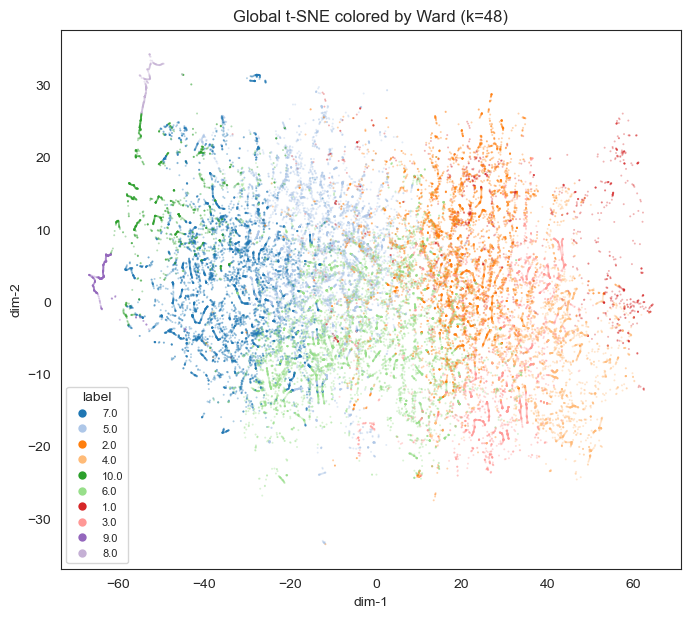

In [19]:
ward_assign = features.WardAssignClustering(params={
    "ward_model": {
        "feature": "global-ward__from__global-tsne",
        "run_id": ward_run,
        "pattern": "model.joblib",
    },
    "artifact": {  # still uses the TSNE templates/scaler space
        "feature": "global-tsne",
        "run_id": tsne_run,
        "pattern": "global_templates_features.npz",
        "load": {"kind": "npz", "key": "templates"},
    },
    "scaler": {
        "feature": "global-tsne",
        "run_id": tsne_run,
        "pattern": "global_opentsne_embedding.joblib",
        "key": "scaler",
    },
    "inputset": "social+ego@v1",   # reuse the preset you saved earlier
    "n_clusters": 10,
    "recalc": False,
})

ward_assign_run = dataset.run_feature(
    ward_assign,
    input_kind="feature",
    input_feature="pair-wavelet__from__pair-posedistance-pca",
)
print("ward-assign run:", ward_assign_run)

viz = features.VizGlobalColored(params={
    "coords": {
        "feature": "global-tsne",
        "run_id": None,
        "pattern": "global_tsne_coords_seq=*.npz",
        "load": {"kind": "npz", "key": "Y"},
    },
    "labels": {
        "feature": "ward-assign__from__global-ward__from__global-tsne",
        "run_id": ward_assign_run,
        "pattern": "*.parquet",
        "load": {"kind": "parquet", "numeric_only": False, "columns": ["cluster"]},
    },
    "coord_key_regex": r"seq=(.+?)(?:_persp=.*)?$",
    "label_key_regex": None,
    "title": "Global t-SNE colored by Ward (k=48)",
})

viz_run_id = dataset.run_feature(viz, input_kind="feature", input_feature="global-tsne")
print("viz run:", viz_run_id)


/Users/jacob/Documents/GitHub/EcodylicScience/behavior/dataset.py:1453: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2025-11-11T10:18:57.416151+00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[sel, "finished_at"] = str(finished_at)


[feature:viz-global-colored__from__global-tsne] completed run_id=0.1-b98243b7e2 -> /Volumes/JD-SSD/ESI-mice/dataset1/features/viz-global-colored__from__global-tsne/0.1-b98243b7e2


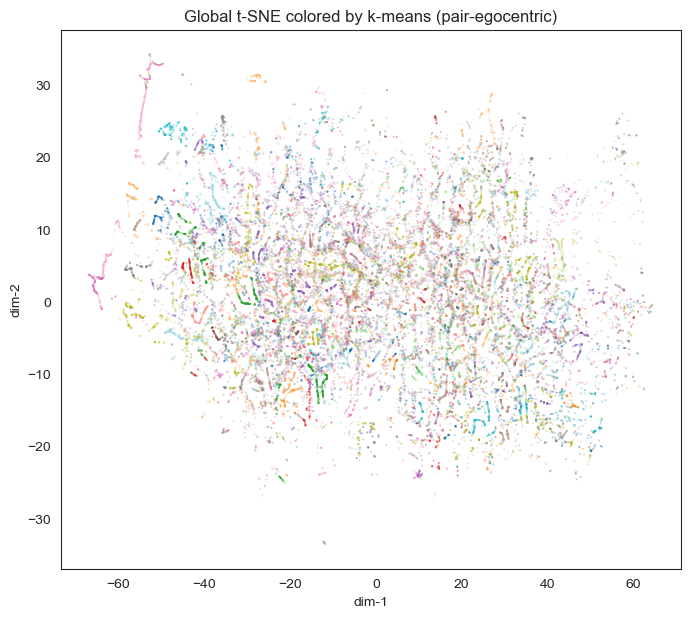

In [8]:
import importlib, features
importlib.reload(features)

viz = features.VizGlobalColored(params={
    "coords": {
        "feature": "global-tsne",
        "run_id": None,
        "pattern": "global_tsne_coords_seq=*.npz",
        "load": {"kind": "npz", "key": "Y"},
    },
    "labels": {
        "feature": "global-kmeans__from__pair-egocentric",
        "run_id": None,
        "pattern": "*.parquet",
        "load": {"kind": "parquet", "numeric_only": False, "columns": ["cluster"]},
    },
    "coord_key_regex": r"seq=(.+)",
    "label_key_regex": r".+",  # <-- let it fall back to the dataset-derived sequence map
    "plot_max": 200_000,
    "title": "Global t-SNE colored by k-means (pair-egocentric)",
})

run_id = dataset.run_feature(viz, input_kind="feature", input_feature="global-tsne")


[feature:viz-global-colored__from__global-tsne] completed run_id=0.1-8597cf5910 -> /Volumes/JD-SSD/ESI-mice/dataset1/features/viz-global-colored__from__global-tsne/0.1-8597cf5910


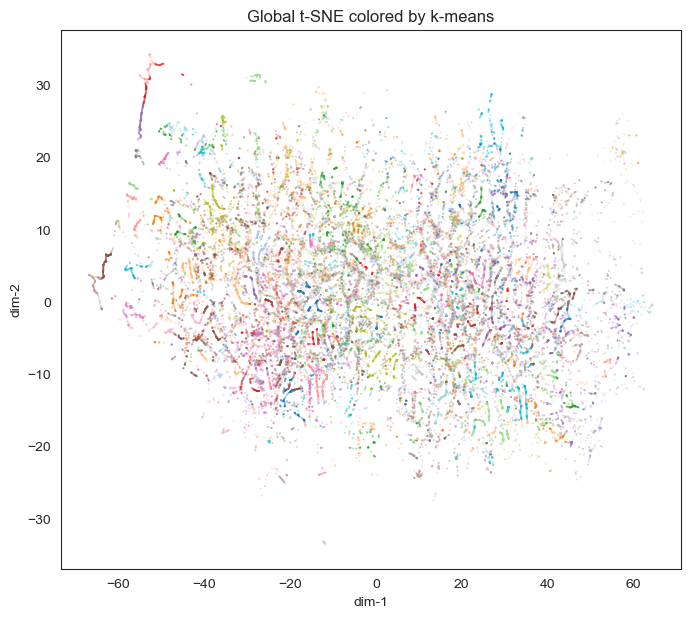

In [9]:
import importlib, features
importlib.reload(features)

viz = features.VizGlobalColored(params={
    "coords": {
        "feature": "global-tsne",
        "run_id": None,
        "pattern": "global_tsne_coords_seq=*.npz",
        "load": {"kind": "npz", "key": "Y"},
    },
    "labels": {
        "feature": "global-kmeans__from__global-tsne",
        "run_id": None,
        "pattern": "global_kmeans_labels_seq=*.npz",
        "load": {"kind": "npz", "key": "labels"},
    },
    "coord_key_regex": r"seq=(.+)",
    "label_key_regex": r"seq=(.+)",
    "plot_max": 200_000,
    "title": "Global t-SNE colored by k-means",
})

run_id = dataset.run_feature(viz, input_kind="feature", input_feature="global-tsne")
